<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/Plots/1Q_Transmon_Calibration_Flux_Dependences_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flux-tunable Qubit Characterization part 1
by Myrron Albert Callera Aguila, PhD (First updated 20231101)

The goal here is to provide flux-calibration functions for a superconducting qubit so that the in-situ parameters needed to map it in energies are extracted, and can be prepared for further calibrations. The algorithms written in the notebook makes sure that key parameters are well characterized in terms of the Hamiltonian. We introduced key parameters here as test of our idea, so that the fit parameters are realistic.

This notebook focuses on extracting $E_{J1}, E_{J2}, d, \gamma$, and the flux period $\Phi_{0}$ from experiment. We also detail how to measure the mutual inductance of the Z-line once the qubit period is resolved, which is a good metric on how the current design is compared with measurements. We hope the codes would be of help in analyzing split transmon devices for CZ and CNOT gate operations.

### Qubit calibration packages

In [ ]:
#Download packages
!pip install lmfit==1.2.2 #updated lmfit

  Using cached numpy-1.19.0.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached lmfit-1.2.2-py3-none-any.whl (102 kB)
  Attempting uninstall: lmfit
    Found existing installation: lmfit 1.0.2
    Uninstalling lmfit-1.0.2:
      Successfully uninstalled lmfit-1.0.2


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import lmfit as lm
import pandas as pd

In [ ]:
from uncertainties import ufloat
from lmfit import Model, Parameters
from lmfit.models import LorentzianModel, SineModel, ExponentialModel, ConstantModel

In [ ]:
#fundamental constants
# set idea
#fundamental constants. obtained from wiki rather than fundamental constants
#from scipy.constants import epsilon_0, mu_0, hbar, k
e0 = 8.8541878128E-12 #F m^s
mu0 = 1.25663706212E-16 #N A^-2
kb = 1.380649E-23 #J K^-1
hbar = 1.054571817E-34 #J s
c = 299792458 # speed of light m s^-2
phi0 = 2.067833848E-15 #Wb
h = 2*np.pi*hbar

## Transmon Tunability with Flux

In this work, we explore qubit frequency limits using the naive qubit frequency tunability function. At $\frac{E_{J}^{'}}{E_{C}} \gg 1$, the relevant qubit first transition frequency and second transition frequency can be approximated as

$$ f_{01}(\Phi) \approx \frac{1}{h} \left( 8 \sqrt{E_{J}^{'}(\Phi)E_{C}} - E_{C} \right) $$

$$ f_{12}(\Phi) \approx f_{01}(\Phi) - \frac{E_{C}}{h} $$

$$ E_{J}^{'}(\Phi) = E_{J}^{max} \left| cos \left( \frac{\pi(\Phi-\Phi_e)}{\Phi_0} \right) \right| \sqrt{1 + d^{2} tan^{2} \left( \frac{\pi (\Phi - \Phi_e)}{\Phi_0} \right) } $$

where $E_J^{max}=E_{J1} + E_{J2}$, and $d=\frac{\gamma-1}{\gamma+1}$ where $\gamma= \frac{E_{J2}}{E_{J1}}$ The fitting parameters in realistic experiments are $E_J^{max}$, $\Phi_{e}$ and $d$. Once the parameters are determined, we establish the following relation via algebraic manipulation:

$$\gamma = \frac{1+d}{1-d}$$

$$E_{J1} = \frac{E_J^{max}}{\gamma + 1}$$

These parameters help evaluate the fidelity of the transmon design to measurement, especially with the $\gamma$ ratio.  

### Demonstration of the qubit flux tunability.

To simplify the notations here, we map $E_J^{'}$ and $E_{C}$ in this program in terms of frequencies (Hertz). In this manner, fitting is easily performed.

In [ ]:
def cm_to_inch(x):
  return x/2.54

def freq_Ej(f01, Ec):
  """
  Determine Ej from f01 and anharmonicity
  input:
    f01 : float
    Resonant frequency in Hz
    Ec : float
    Charging Energy in Hz

  return
  """
  f_Ej = ((f01+Ec)/8)**2/Ec
  return f_Ej

def Ej_phi(phi, Ejmax, gam, phi_e):
  """
  Ej as a function of external flux phi
  input:
    phi : 1D numpy array
      external flux as a function of quanta
    Ejmax : float
      Total Ej in units of Hz
    d : float
      Junction asymmetry parameter
    phi_e : float
      flux offset
  """
  d = (gam-1)/(gam+1)
  A = np.pi*(phi + phi_e)/phi0
  B = Ejmax*np.abs(np.cos(A))
  C = np.sqrt(1+(d*np.tan(A))**2)
  return B*C

def f_01_phi(phi, Ejmax, gam, phi_e, Ec):
  """
  Ec here is fixed.
  input:
    phi : 1D numpy array
      external flux as a function of quanta
    Ejmax : float
      Total Ej in units of Hz
    d : float
      Junction asymmetry parameter
    phi_e : float
      flux offset
    Ec : float
      charging energy in units of Hz
  return:

  """
  f01 = np.sqrt(8*Ej_phi(phi, Ejmax, gam, phi_e)*Ec) - Ec
  return f01

def f_12_phi(phi, Ejmax, gam, phi_e, Ec):
  """
  Ec here is fixed.
  input:
    phi : 1D numpy array
      external flux as a function of quanta
    Ejmax : float
      Total Ej in units of Hz
    d : float
      Junction asymmetry parameter
    phi_e : float
      flux offset
    Ec : float
      charging energy in units of Hz
  return:
  """
  f12 = f_01_phi(phi, Ejmax, gam, phi_e, Ec) - Ec
  return f12

def Ej1_Ej2_d(Ejmax, gam):
  """
  Extract Ej1, Ej2 and d from the split transmon
  input:
    Ejmax : float / ufloat
      josephson energy
    gam : float / ufloat
      ratio of EJ2/Ej1
  """
  Ej1 = Ejmax/(gam+1)
  Ej2 = Ejmax - Ej1
  d = (gam-1)/(gam+1)
  return Ej1, Ej2, d

Plot the qubit frequencies and check different qubit regimes. (Replicate Krantz[2] Figure 2 calculations for symmetric and asymmetric transmon).

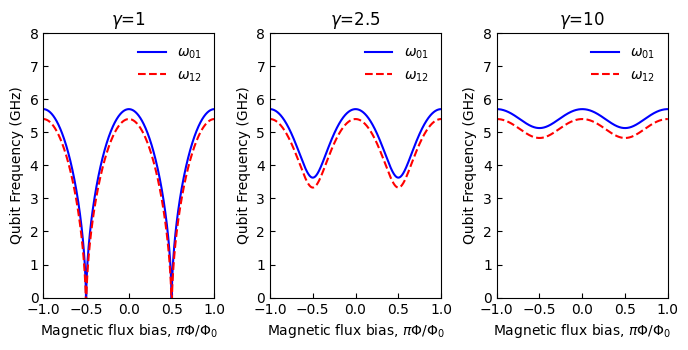

In [ ]:
#Set parameters
Ejmax_1 = 15E9 #15 GHz
Ec_1 = 0.3E9 #300 MHz
phi_e0 = 0.0
phi_e1 = 0.2
gam0 = 1
gam1 = 2.5
gam2 = 10

phi_arr = np.linspace(-1, 1, 1001)*phi0
# model f01 and f12 as a function of flux

#first case, Ej1=Ej2
f01_0 = f_01_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam0, phi_e=phi_e0, Ec=Ec_1)
f12_0 = f_12_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam0, phi_e=phi_e0, Ec=Ec_1)

#second case, Ej1<Ej2
f01_1 = f_01_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam1, phi_e=0, Ec=Ec_1)
f12_1 = f_12_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam1, phi_e=0, Ec=Ec_1)

#third case, Ej1<<Ej2
f01_2 = f_01_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam2, phi_e=0, Ec=Ec_1)
f12_2 = f_12_phi(phi=phi_arr, Ejmax=Ejmax_1, gam=gam2, phi_e=0, Ec=Ec_1)

a1 = 1/phi0
b1 = 1E-9

# plot data
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(8.6),
                                                   cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0]) #f01, f12, vary gamma=1
ax1 = fig.add_subplot(spec[0, 1]) #f01, f12, vary gamma=2.5
ax2 = fig.add_subplot(spec[0, 2]) #f01, f12, vary gamma=10

#scale*Qinv
ax0.set_title(r'$\gamma$='+str(gam0))
ax0.plot(a1*phi_arr, b1*f01_0, 'b-', label=r'$\omega_{01}$')
ax0.plot(a1*phi_arr, b1*f12_0, 'r--', label=r'$\omega_{12}$')
ax0.set_xlabel(r'Magnetic flux bias, $\pi\Phi/\Phi_0$')
ax0.set_ylabel('Qubit Frequency (GHz)')
ax0.set_xlim(-1,1)
ax0.set_ylim(0,8)
ax0.tick_params(axis='both', direction='in')
ax0.legend(loc='best', frameon=False)

ax1.set_title(r'$\gamma$='+str(gam1))
ax1.plot(a1*phi_arr, b1*f01_1, 'b-', label=r'$\omega_{01}$')
ax1.plot(a1*phi_arr, b1*f12_1, 'r--', label=r'$\omega_{12}$')
ax1.set_xlabel(r'Magnetic flux bias, $\pi\Phi/\Phi_0$')
ax1.set_ylabel('Qubit Frequency (GHz)')
ax1.set_xlim(-1,1)
ax1.set_ylim(0,8)
ax1.tick_params(axis='both', direction='in')
ax1.legend(loc='best', frameon=False)

ax2.set_title(r'$\gamma$='+str(gam2))
ax2.plot(a1*phi_arr, b1*f01_2, 'b-', label=r'$\omega_{01}$')
ax2.plot(a1*phi_arr, b1*f12_2, 'r--', label=r'$\omega_{12}$')
ax2.set_xlabel(r'Magnetic flux bias, $\pi\Phi/\Phi_0$')
ax2.set_ylabel('Qubit Frequency (GHz)')
ax2.set_xlim(-1,1)
ax2.set_ylim(0,8)
ax2.tick_params(axis='both', direction='in')
ax2.legend(loc='best', frameon=False)

plt.show()
#The model works

Ref [1] has added $\pi$ to make sure that in two periods, the flux vary by +1 or -1 when normalized by $\pi \Phi/\Phi_0$

Data Analysis

In [ ]:
def read_csv(fname):
  """
  Analyze Data from CSV files (check if you have header)
  """
  df = pd.DataFrame(pd.read_csv(fname + '.csv', header=None))
  #column 0 - x-axis
  #column 1 - y-axis
  return df

def find_nearest(array, value):
  """Find index and element to an array to which its value is nearest to the
  reference value"""
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return idx, array[idx]

def guess_params_f01(xdata, ydata, Ec):
  """
  Extract good guess parameters from ydata
  """

  #get Ejmax and get its index
  idx_f01_max, f01_max = find_nearest(array=ydata, value=np.amax(ydata))
  Ej_m = freq_Ej(f01=f01_max, Ec=Ec)

  #get offset location
  x_offset = xdata[idx_f01_max]

  #get period from one minimum branch
  idx_f01_min, f01_min = find_nearest(array=ydata, value=np.amin(ydata))
  x_min = xdata[idx_f01_min]
  if x_min < x_offset:
    period = 2*(x_offset - x_min)
  else:
    period = 2*(x_min - x_offset)

  #get Ej_min
  Ej_min = freq_Ej(f01=f01_min, Ec=Ec)

  dict_guess = {'Ej_max': Ej_m,
                'Ej_min': Ej_min,
                'phi_ofs': x_offset,
                'Ec': Ec,
                'period': period}
  return dict_guess

def lm_f01_phi(xdata, ydata, guess, show=['Y', 'Y']):
  """
  Extracting Ejmax, gamma and phi_e from the model
  Input:
    xdata : 1D numpy array
        Photon number user supplied
    ydata : 1D numpy array
        measured 1/Qi
    guess : list of floats
        guess[0] = Ejmax
        guess[1] = gamma
        guess[2] = phi_e in units of phi_0
        guess[3] = Ec #not a guess but an arg
    show : list of floats
        show[0] = 'Y' => show fit report
        show[1] = 'Y' => show fit plot
  """

  # guess function based on curve behavior
  dict_g = guess_params_f01(xdata, ydata, guess[3])
  print(dict_g['Ej_max'])
  print(dict_g['Ej_min'])

  # set model and parameters
  mod = Model(f_01_phi)
  par = ['Ejmax', 'gam', 'phi_e', 'Ec'] #name of fitting functions
  p = np.asarray([guess[0], guess[1], guess[2], guess[3]]) #values of the functions
  params = Parameters()
  # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
  # time in nanosecond
  # guess = pars_exp['exp_decay'].value

  #we have four parameter fits
  print(par)
  print(p)

  #1/Qtls -> means lower Q, tls dominates. At higher power, other Qr dominates.
  params.add_many((par[0], p[0], True, 1E9, 1E11),
                  (par[1], p[1], True, 0.0, 50.0),
                  (par[2], p[2], True, -0.6, 0.6),
                  (par[3], p[3], False))
  """
  Ref [1] => tells that Q_inv_t, Q_inv_nt, phi and
  nc are free parameters of the fit
  """

  init = mod.eval(params, phi=xdata)
  #out = mod.fit(ydata, params, phi=xdata, scale_covar=True, method='nelder') #gives good exact fit without errors
  #out = mod.fit(ydata, params, phi=xdata, scale_covar=True, method='least_squares')
  out = mod.fit(ydata, params, phi=xdata, scale_covar=True, method='leastsq') #levenberg-Marquardt

  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))

  if show[1] == 'Y':
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(8.6),
                                                       cm_to_inch(8.6)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig,
                             hspace =0.05, wspace=0.05)
    axes = fig.add_subplot(spec[0, 0])
    axes.plot(xdata, ydata, 'k.')
    axes.plot(xdata, init, 'b:', label='initial fit')
    axes.plot(xdata, out.best_fit, 'ro', label='best fit')
    axes.set_xlabel(r'Normalized Flux $\Phi / \Phi_0$', fontsize=12)
    axes.set_ylabel(r'Qubit Frequency (Hz)',fontsize=12)
    axes.tick_params(direction='in', right=True, top=True, labelsize=12)
    axes.legend()

  """Method - iterable dictionaries {} more efficient. Names are keys and the dictionary
  contains a list. [0] refers to best fit whereas [1] would be the standard error"""
  out_dict_val_stderr = {par[i]: [out.params[par[i]].value, out.params[par[i]].stderr]
  for i in range(len(par))}

  return out.best_fit, out_dict_val_stderr

We replot Figure 7 from [3] as test system for fit (QB1 $E_j$/h=12.2 GHz, $E_c$/h=0.195 GHz; CPLR $E_{j1}$/h=46 GHz, $E_{j2}$/h=25 GHz, Ec/h=0.085 GHz; QB2 $E_{j1}$=13GHz, $E_{j2}$/h=2.8 GHz, Ec/h=0.19 GHz).
These data have been extracted from literature.

In real experiments, the guess Ej usually assumes symmetry or by CAD, or better by resistance measurement having an assumption of a bulk Tc gap for aluminum. This can be estimated by the Ambegaokar-Barattoff relation, which is a good reference for the accuracy of the qubit between room temperature and low-temperature conditions.

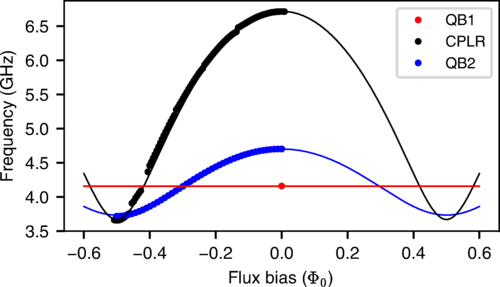

We see the normalized flux here to be written in a way that $$\Phi_{0,YK}=\frac{\Phi}{\Phi_0}$$ where $\Phi_{0,YK}$ is unitless.
This can be corrected by getting a good correction factor.
$$\Phi=\Phi_0 \Phi_{0,YK}$$

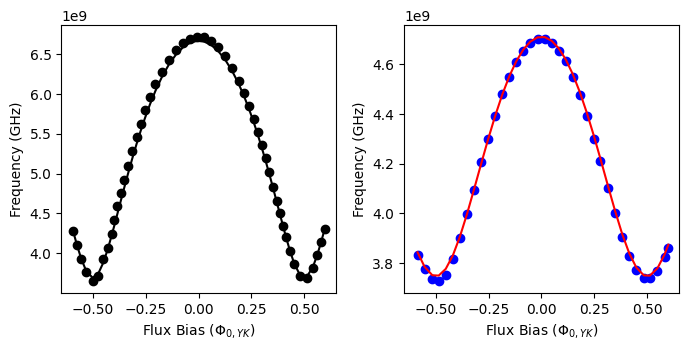

In [ ]:
fname1 = 'CPLR_YKS'
fname2 = 'QB2_YKS'

"""Extract Plots"""
df_cplr = read_csv(fname1)
df_qbt2 = read_csv(fname2)

a2 = 1
b2 = 1E9 #GHz to Hz

phi_cplr = df_cplr[0].to_numpy() #normalized flux 0.5 = np.pi/2
freq_cplr = df_cplr[1].to_numpy()

phi_qbt2 = df_qbt2[0].to_numpy() #normalized flux 0.5 = np.pi/2
freq_qbt2 = df_qbt2[1].to_numpy()

#print(phi_cplr)
#print(freq_cplr)
#print(phi_qbt2)
#print(freq_qbt2)

#corr_phi = phi0/np.pi #turned wrong
corr_phi = phi0 #correction to notation from Data

"""Key Information"""
Ej1_cplr = 44*b2 #GHz to Hz #originally 46
Ej2_cplr = 23*b2 #GHz to Hz #originally 25
Ejmax_cplr = Ej1_cplr + Ej2_cplr
gam_cplr = Ej2_cplr/Ej1_cplr
Ec_cplr = 0.085*b2
phi_cplr_e = 0
guess_cplr = [Ejmax_cplr, gam_cplr, phi_cplr_e, Ec_cplr]
f01_cplr = f_01_phi(corr_phi*phi_cplr, Ejmax_cplr, gam_cplr, phi_cplr_e, Ec_cplr)

Ej1_qbt2 = 13*b2 #GHz to Hz
Ej2_qbt2 = 2.8*b2 #GHz to Hz
Ejmax_qbt2 = Ej1_qbt2 + Ej2_qbt2
gam_qbt2 = Ej2_qbt2/Ej1_qbt2
Ec_qbt2 = 0.19*b2
phi_qbt2_e = 0
guess_qbt2 = [Ejmax_qbt2, gam_qbt2, phi_qbt2_e, Ec_qbt2]
f01_qbt2 = f_01_phi(corr_phi*phi_qbt2, Ejmax_qbt2, gam_qbt2, phi_qbt2_e, Ec_qbt2)

# plot data
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(8.6),
                                                   cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0]) #f01, f12, vary gamma=1


ax0.plot(phi_cplr, freq_cplr*b2, 'ko', label='CPLR') #noisy data
ax0.plot(phi_cplr, f01_cplr, 'k-', label='CPLR-init')
ax0.set_xlim(-0.65, 0.65)
#ax0.set_ylim(3.5, 7.0)
ax0.set_xlabel(r'Flux Bias ($\Phi_{0,YK}$)')
ax0.set_ylabel(r'Frequency (GHz)')

ax1 = fig.add_subplot(spec[0, 1]) #f01, f12, vary gamma=1
ax1.plot(phi_qbt2, freq_qbt2*b2, 'bo', label='QB2')
ax1.plot(phi_qbt2, f01_qbt2, 'r-', label='QB2-init') #noisy data
ax1.set_xlim(-0.65, 0.65)
#ax0.set_ylim(3.5, 7.0)
ax1.set_xlabel(r'Flux Bias ($\Phi_{0,YK}$)')
ax1.set_ylabel(r'Frequency (GHz)')
plt.show()

#we see it is not a good fit in terms of bandwidth$

8489878015.1654415
2576353780.165441
['Ejmax', 'gam', 'phi_e', 'Ec']
[6.70000000e+10 5.22727273e-01 0.00000000e+00 8.50000000e+07]
[[Model]]
    Model(f_01_phi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 52
    # variables        = 3
    chi-square         = 1.3990e+17
    reduced chi-square = 2.8551e+15
    Akaike info crit   = 1853.47920
    Bayesian info crit = 1859.33293
    R-squared          = 0.99745445
[[Variables]]
    Ejmax:  6.7000e+10 +/- 2.5838e+08 (0.39%) (init = 6.7e+10)
    gam:    0.52272727 +/- 0.00411043 (0.79%) (init = 0.5227273)
    phi_e:  0.00000000 +/- 5.7957e-08 (inf%) (init = 0)
    Ec:     8.5e+07 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(Ejmax, gam)   = +0.6773
    C(gam, phi_e)   = +0.4828
    C(Ejmax, phi_e) = +0.2820


/usr/local/lib/python3.10/dist-packages/lmfit/printfuncs.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


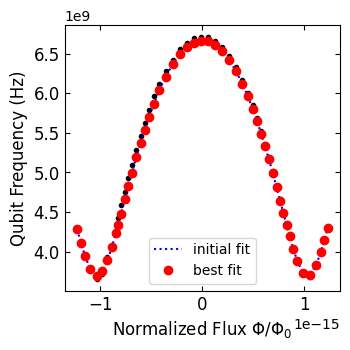

In [ ]:
#perform fitting algorithm
fit_cplr, dict_cplr = lm_f01_phi(xdata=corr_phi*phi_cplr*a2,
                                 ydata=freq_cplr*b2,
                                 guess=guess_cplr, show=['Y', 'Y'])

1968845018.1661184
1263639079.350329
['Ejmax', 'gam', 'phi_e', 'Ec']
[1.58000000e+10 2.15384615e-01 0.00000000e+00 1.90000000e+08]
[[Model]]
    Model(f_01_phi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 37
    # variables        = 3
    chi-square         = 3.5315e+15
    reduced chi-square = 1.0387e+14
    Akaike info crit   = 1197.01469
    Bayesian info crit = 1201.84744
    R-squared          = 0.99925592
[[Variables]]
    Ejmax:  1.5800e+10 +/- 19498535.5 (0.12%) (init = 1.58e+10)
    gam:    0.21538462 +/- 0.00111512 (0.52%) (init = 0.2153846)
    phi_e:  0.00000000 +/- 4.4013e-08 (inf%) (init = 0)
    Ec:     1.9e+08 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(Ejmax, gam)   = +0.7824
    C(gam, phi_e)   = +0.4677
    C(Ejmax, phi_e) = +0.3091


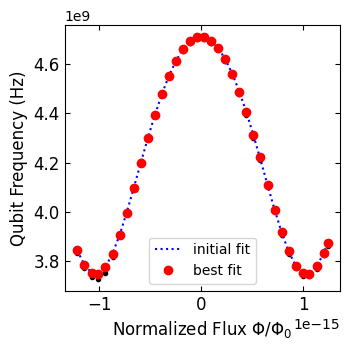

In [ ]:
#perform fitting algorithm on the other qubit
fit_qbt2, dict_qbt2 = lm_f01_phi(xdata=corr_phi*phi_qbt2*a2,
                                 ydata=freq_qbt2*b2,
                                 guess=guess_qbt2, show=['Y', 'Y'])
# does not converge due to outstanding high values.

The order is off because the original paper talks [2] about it in flux, whereas in this paper [1], the solution is addressed as Normalized flux times the flux quanta. The fits are in good agreement. Quite unfortunately though, if we do not contrain the expression, it would lead to multiple local minima. Hence, sometimes having good guess helps a lot in the extraction. One can do it manually by plugging in different variables that can minimize the residual error. If we develop brute-force iteration of fits, this can be taken care off.

Getting the key parameters of the transmon: $Ej_1$, $Ej_2$ and $\gamma$ with good precision

In [ ]:
#cplr qubit, no offset, with uncertainties
Ejmax_cplr_fit = ufloat(dict_cplr['Ejmax'][0], dict_cplr['Ejmax'][1])
gam_cplr_fit = ufloat(dict_cplr['gam'][0], dict_cplr['gam'][1])
Ej1_cplr_fit, Ej2_cplr_fit, d_cplr_fit = Ej1_Ej2_d(Ejmax_cplr_fit, gam_cplr_fit)
print(Ejmax_cplr_fit/1E9) #GHz

#qbt2, no offset, with uncertainties
Ejmax_qbt2_fit = ufloat(dict_qbt2['Ejmax'][0], dict_qbt2['Ejmax'][1])
gam_qbt2_fit = ufloat(dict_qbt2['gam'][0], dict_qbt2['gam'][1])
Ej1_qbt2_fit, Ej2_qbt2_fit, d_qbt2_fit = Ej1_Ej2_d(Ejmax_qbt2_fit, gam_qbt2_fit)

"""Report Ej1, Ej2 and d for direct hamiltonian representation"""
print('Coupler Qubit Parameters')
print('Ej1 = {:.9f} GHz'.format(Ej1_cplr_fit/1E9)) # 46 GHz in paper
print('Ej2 = {:.9f} GHz'.format(Ej2_cplr_fit/1E9)) # 25 GHz in paper
print('d = {:.3f}'.format(d_cplr_fit))
print('gamma = {:.3f}'.format(gam_cplr_fit))
print('Ec = {:3f} GHz'.format(Ec_cplr/1E9))
print('\n')

print('QBT2 Parameters')
print('Ej1 = {:.9f} GHz'.format(Ej1_qbt2_fit/1E9)) # 13 GHz in paper
print('Ej2 = {:.9f} GHz'.format(Ej2_qbt2_fit/1E9)) # 2.8 GHz in paper
print('d = {:.3f}'.format(d_qbt2_fit))
print('gamma = {:.3f}'.format(gam_qbt2_fit))
print('Ec = {:3f} GHz'.format(Ec_qbt2/1E9))

67.00+/-0.26
Coupler Qubit Parameters
Ej1 = 44.000000000+/-0.207122790 GHz
Ej2 = 23.000000000+/-0.148237941 GHz
d = -0.313+/-0.004
gamma = 0.523+/-0.004
Ec = 0.085000 GHz


QBT2 Parameters
Ej1 = 13.000000000+/-0.019991213 GHz
Ej2 = 2.800000000+/-0.012418037 GHz
d = -0.646+/-0.002
gamma = 0.215+/-0.001
Ec = 0.190000 GHz


We can then reconstruct the $f_{01}$ and $f_{12}$ transitions of different qubit to predict plausible operation points for CNOT operation.

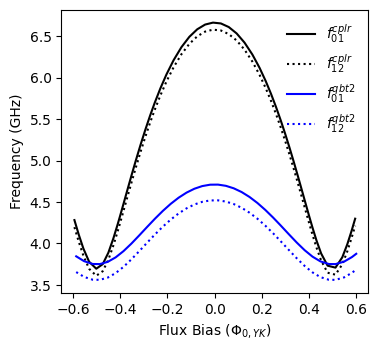

In [ ]:
# CPLR Qubit
f01_cplr_phi = f_01_phi(corr_phi*phi_cplr, Ejmax_cplr_fit.n, gam_cplr_fit.n,
                        phi_cplr_e, Ec_cplr)
f12_cplr_phi = f_12_phi(corr_phi*phi_cplr, Ejmax_cplr_fit.n, gam_cplr_fit.n,
                        phi_cplr_e, Ec_cplr)

# QBT2
f01_qbt2_phi = f_01_phi(corr_phi*phi_qbt2, Ejmax_qbt2_fit.n, gam_qbt2_fit.n,
                        phi_qbt2_e, Ec_qbt2)
f12_qbt2_phi = f_12_phi(corr_phi*phi_qbt2, Ejmax_qbt2_fit.n, gam_qbt2_fit.n,
                        phi_qbt2_e, Ec_qbt2)

# plot data
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(8.6),
                                                   cm_to_inch(8.6)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)

ax0 = fig.add_subplot(spec[0, 0]) #f01, f12, vary gamma=1

b2=1E-9
ax0.plot(phi_cplr, f01_cplr_phi*b2, 'k-', label=r'$f_{01}^{cplr}$') #f01_cplr
ax0.plot(phi_cplr, f12_cplr_phi*b2, 'k:', label=r'$f_{12}^{cplr}$') #f12_cplr
ax0.plot(phi_qbt2, f01_qbt2_phi*b2, 'b-', label=r'$f_{01}^{qbt2}$') #f01_cplr
ax0.plot(phi_qbt2, f12_qbt2_phi*b2, 'b:', label=r'$f_{12}^{qbt2}$') #f12_cplr
ax0.set_xlim(-0.65, 0.65)
ax0.set_xlabel(r'Flux Bias ($\Phi_{0,YK}$)')
ax0.set_ylabel(r'Frequency (GHz)')
ax0.legend(loc='best', frameon=False)
plt.show()

###Incomplete Flux Measurement Test

Another test that can be done is to have a best fit of the data if say we missed measuring the inflection points to have a good period. Can we still extract the qubit parameters without observing the flux period? We test that using the fits of the previous qubits. For the coupler qubit, and qubit 2 of Oliver's work, this can be done via flux compensation.

8489878015.1654415
3116553915.6066184
['Ejmax', 'gam', 'phi_e', 'Ec']
[6.70000000e+10 5.22727273e-01 0.00000000e+00 8.50000000e+07]
[[Model]]
    Model(f_01_phi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 37
    # variables        = 3
    chi-square         = 1.3485e+17
    reduced chi-square = 3.9662e+15
    Akaike info crit   = 1331.78545
    Bayesian info crit = 1336.61820
    R-squared          = 0.99483270
[[Variables]]
    Ejmax:  6.7000e+10 +/- 3.2732e+08 (0.49%) (init = 6.7e+10)
    gam:    0.52272727 +/- 0.00832640 (1.59%) (init = 0.5227273)
    phi_e:  0.00000000 +/- 7.4740e-08 (inf%) (init = 0)
    Ec:     8.5e+07 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(Ejmax, gam) = +0.6512


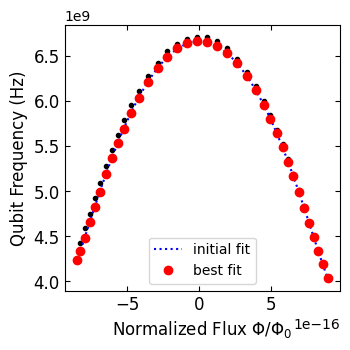

In [ ]:
#perform fitting algorithm
i = 8 #start index (not be considered)
j = len(phi_cplr)-(i-1) #end index (not be considered)
phi_cplr_mod = phi_cplr[i:j]
freq_cplr_mod = freq_cplr[i:j]
fit_cplr, dict_cplr = lm_f01_phi(xdata=corr_phi*phi_cplr_mod*a2,
                                 ydata=freq_cplr_mod*b2,
                                 guess=guess_cplr, show=['Y', 'Y'])

1968845018.1661184
1380352075.7894738
['Ejmax', 'gam', 'phi_e', 'Ec']
[1.58000000e+10 2.15384615e-01 0.00000000e+00 1.90000000e+08]
[[Model]]
    Model(f_01_phi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 22
    # variables        = 3
    chi-square         = 1.1672e+15
    reduced chi-square = 6.1431e+13
    Akaike info crit   = 701.251366
    Bayesian info crit = 704.524493
    R-squared          = 0.99909335
[[Variables]]
    Ejmax:  1.5800e+10 +/- 16414369.5 (0.10%) (init = 1.58e+10)
    gam:    0.21538462 +/- 0.00170194 (0.79%) (init = 0.2153846)
    phi_e:  0.00000000 +/- 4.0037e-08 (inf%) (init = 0)
    Ec:     1.9e+08 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(Ejmax, gam) = +0.6844


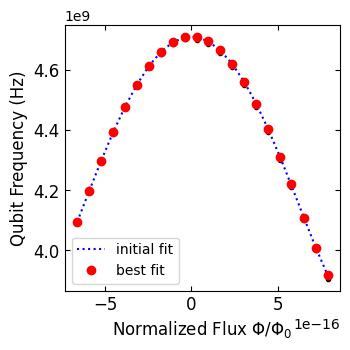

In [ ]:
#perform fitting algorithm
i = 8 #start index (not be considered)
j = len(phi_qbt2)-(i-1) #end index (not be considered)
phi_qbt2_mod = phi_qbt2[i:j]
freq_qbt2_mod = freq_qbt2[i:j]
fit_qbt2, dict_qbt2 = lm_f01_phi(xdata=corr_phi*phi_qbt2_mod*a2,
                                 ydata=freq_qbt2_mod*b2,
                                 guess=guess_qbt2, show=['Y', 'Y'])

Even with limited flux offsets, we can acquire the fit with good accuracy.

###Extracting mutual inductance from flux lines

In real experiments, the transmon is biased at the flux lines, converting the applied voltage to a current $I$ that creates a magnetic field from the mutual inductance $M$. To simplify the calibration and map it to a flux, one period of the flux line is equivalent to a flux quanta $\Phi_{0}$, hence simplifying the calibration from voltage to flux. The component also helps reveal the mutual inductance, to see if it helps improve the design of the flux line.

$$\frac{\pi (\Phi-\Phi_e)}{\Phi_0} = \frac{(V-V_e)}{V_{c}} = \frac{(I-I_e)}{I_c}$$

Modelling the flux line as a quantized inductor, the Mutual inductance is equivalent to the Josephson inductance required to the qubit to get a full period of the qubit).

$$L_M = \frac{\Phi_0}{I_{c}}$$

As normal flux pulses are controlled by AWG voltages $V_{DC}$ starting from 0 volts that are attenuated by the flux line with power attenuation $A_{tot}$ with a characteristic impedance $Z_{0}=50 \Omega$, the bias voltage $V_{c}$ has the following relation with the $I_{c}$ and $V_{DC}$:

$$V_{c} = 2\sqrt{A_{tot}} (V_{DC,period}-V_{offs}) = I_{c}Z_{0} \rightarrow I_{c} = \frac{2\sqrt{A_{tot}} (V_{DC,half period}-V_{offs})}{Z_{0}}$$

Given this relation, one can calibrate the peaks well. In the case of symmetric josephson Junction though, these types of measurements must be carried out with cavity measurements to make the fits easier.

In [ ]:
def dB_to_mag(x):
  """Convert dB to S21 magnitude"""
  return 20*np.log10(x)

def Vdc_to_Ic(Vdc, Voffs, attn):
  """
  Convert Ic from Vdc voltage
  assume symmetric period, and an impedance of 50 ohm
  Input:
    Vdc : float
      Vdc where periodicity is obtained
    Voffs: float
      Voffset
    attn : float
      Attenuation in dB
  """
  exp = 2*np.sqrt(dB_to_mag(attn))*(Vdc-Voffs)/50
  return exp

def Lm(Ic):
  """
  Estimate Mutual Inductance from flux quantum
  1. useful in debugging M from design to test M'
  input :
    Ic : float
      critical current where we get one flux period of the qubit
  return :
    float
  """
  return phi0/Ic

def Voffs_to_phi_e(Ie, Ic):
  """
  Convert flux offset to external flux quanta:
  input :
    x : float
      flux offset
  """
  phi_e = phi0*(Ie/Ic)
  """
  note that phi_e and phi_0 ignores the np.pi that was used by the transmon
  community to identify phase.
  """
  return phi_e

Typical flux gates have inductances of $L=4\,pH$. However, one may need an autocalibrated effort to make sure the designed inductance works as intended. Also, every qubit will have a special voltage period $V_{c}$ which maps out to flux quanta we call $\Phi_0,Qi$. These parameters will later be crucial in setting up DC flux compensation matrix with respect to the flux quanta of each qubit.

#References

1. Koch, J. Y., Terri M.; Gambetta, Jay Gambetta; Houck, A. A. ; Schuster, D. I.; Majer, J.; Blais, Alexander; Devoret, M. H.; Girvin, S. M.; Schoelkopf, R. J. (2007). Charge-insensitive qubit design derived from the Cooper pair box. Phys. Rev. A., 76, 042319. doi:10.1103/PhysRevA.76.042319
2. Krantz, P., Kjaergaard, M., Yan, F., Orlando, T. P., Gustavsson, S., & Oliver, W. D. (2019). A quantum engineer's guide to superconducting qubits. Applied Physics Reviews, 6(2), 021318. doi:10.1063/1.5089550
3. Sung, Y., Ding, L., Braumüller, J., Vepsäläinen, A., Kannan, B., Kjaergaard, M., . . . Oliver, W. D. (2021). Realization of High-Fidelity CZ and
ZZ -Free iSWAP Gates with a Tunable Coupler. Physical Review X, 11(2). doi:10.1103/PhysRevX.11.021058